## Dynamic tree attention for MEDUSA

This notebook demonstrates how to use the dynamic tree attention mechanism for the MEDUSA model. We suppose you are already familiar with the MEDUSA model and its implementation. Let's first import the libraries (we assume you have already installed the `medusa` package).



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # define GPU id, remove if you want to use all GPUs available
import torch
import numpy as np
from medusa.model.medusa_model import MedusaModel
from medusa.model.kv_cache import *
import medusa.model.utils as utils
from medusa.model.medusa_choices import * 
import matplotlib.pyplot as plt

# code for dynamic tree attention is in this file
from medusa_dynamic import *


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the `medusa-vicuna-7b-v1.3` model. This model requires at least 14GB GPU memory to run.
If you are first time loading the model, it will take some time to download the weights. Once the weights are downloaded, it will take 1-3 minutes to load it from hard disk to GPU.

In [2]:
model_name = 'FasterDecoding/medusa-vicuna-7b-v1.3'
model = MedusaModel.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto"
)
tokenizer = model.get_tokenizer()

# this is the fixed tree structure for MEDUSA
medusa_choices = mc_sim_7b_63

# initialize past key values
past_key_values, past_key_values_data, current_length_data = initialize_past_key_values(model.base_model)
model.past_key_values = past_key_values
model.past_key_values_data = past_key_values_data
model.current_length_data = current_length_data

LlamaForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that th

### Visualize the fixed tree structure of MEDUSA.

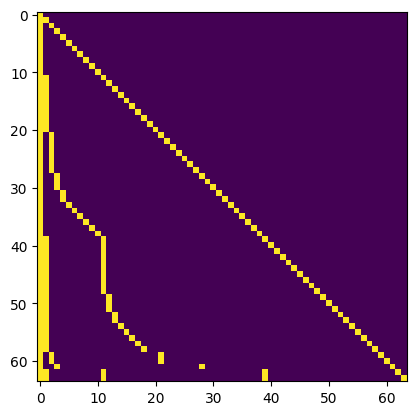

In [18]:
medusa_buffers = utils.generate_medusa_buffers(
    medusa_choices, device=model.base_model.device
)

mask = medusa_buffers["medusa_attn_mask"].cpu().numpy()[0, 0]
plt.imshow(mask)
plt.show()

### Visualize the dynamic tree structure of MEDUSA.
Because it is dynamic, we need to set in input and run the model.

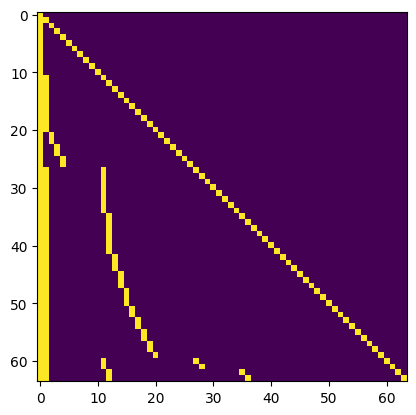

In [21]:
prompt = "Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions."
with torch.inference_mode():
    input_ids = tokenizer([prompt]).input_ids
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    reset_medusa_mode(model)
    medusa_logits, logits = initialize_medusa(
            input_ids, model, past_key_values
        )
    # topk is the same as MEDASA for visualization purposes
    M = MultiTokenGenerator(topk=10)
    candidates, tree_candidates, medusa_buffers = M.generate_candidates(
        medusa_logits, 
        logits,
    )

mask = medusa_buffers["medusa_attn_mask"].cpu().numpy()
plt.imshow(mask)
plt.show()

Let's change the prompt and see how the tree structure changes. 

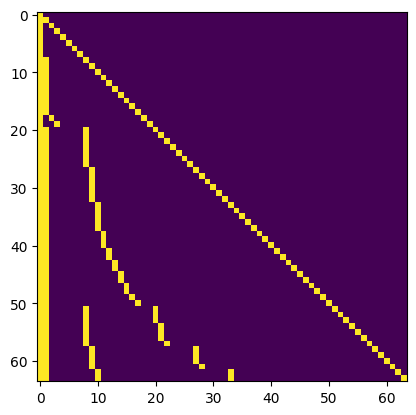

In [20]:
prompt = "Describe a vivid and unique character, using strong imagery and creative language. Please answer in fewer than two paragraphs."
with torch.inference_mode():
    input_ids = tokenizer([prompt]).input_ids
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    reset_medusa_mode(model)
    medusa_logits, logits = initialize_medusa(
            input_ids, model, past_key_values
        )
    # topk is the same as MEDASA for visualization purposes
    M = MultiTokenGenerator(topk=10)
    candidates, tree_candidates, medusa_buffers = M.generate_candidates(
        medusa_logits, 
        logits,
    )

mask = medusa_buffers["medusa_attn_mask"].cpu().numpy()
plt.imshow(mask)
plt.show()

### Speed up comparison
We measure speed up via tokens per model inference. We first run MEDUSA, then run MEDUSA with dynamic tree attention. For demonstration, we
set `temperature=0` for deterministic generation. We set `topk=32` for dynamic tree.

In [9]:
prompt = "Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions."

accept_lengths_tree = []
with torch.inference_mode():
    new_token = 0
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    utils.reset_medusa_mode(model)
    medusa_buffers = utils.generate_medusa_buffers(
                medusa_choices, device=model.base_model.device
            )

    medusa_logits, logits = utils.initialize_medusa(
            input_ids, model, medusa_buffers["medusa_attn_mask"], past_key_values
        )
    cur_length = input_len + 1
    accept_lengths_tree.append(1)
    
    for i in range(512):
        candidates, tree_candidates = utils.generate_candidates(
                medusa_logits,
                logits,
                medusa_buffers["tree_indices"],
                medusa_buffers["retrieve_indices"],
            )
        
        medusa_logits, logits, outputs = utils.tree_decoding(
                model,
                tree_candidates,
                past_key_values,
                medusa_buffers["medusa_position_ids"],
                input_ids,
                medusa_buffers["retrieve_indices"],
            )

        best_candidate, accept_length = utils.evaluate_posterior(
                logits, candidates, temperature = 0, posterior_threshold = 0.09, posterior_alpha = 0.3
            )
        input_ids, logits, medusa_logits, new_token = utils.update_inference_inputs(
                input_ids,
                candidates,
                best_candidate,
                accept_length,
                medusa_buffers["retrieve_indices"],
                outputs,
                logits,
                medusa_logits,
                new_token,
                past_key_values_data,
                current_length_data,
            )
        
        accept_length_tree = input_ids.shape[1] - cur_length
        cur_length = accept_length_tree + cur_length
        accept_lengths_tree.append(accept_length_tree)
        if model.tokenizer.eos_token_id in input_ids[0, input_len:]:
            break
print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))

Decode: ["\nWrite a persuasive essay arguing for or against the use of standardized testing in schools.\nCreate a short story that incorporates elements of magical realism, exploring themes of identity and self-discovery.\nWrite a review of a recent concert or live performance, discussing the music, the atmosphere, and the overall experience.\nDevelop a comprehensive business plan for a new startup, outlining market research, target audience, marketing strategies, and financial projections.\nWrite a research paper exploring the impact of social media on mental health, analyzing studies and statistics and presenting your own findings.\nWrite a personal essay reflecting on a significant life event or experience, exploring how it has shaped your values and worldview.\nWrite a persuasive essay arguing for or against the use of capital punishment, considering ethical, legal, and practical implications.\nCreate a detailed lesson plan for a high school English class, outlining objectives, act

In [10]:
accept_lengths_tree_plus = []
with torch.inference_mode():
    new_token = 0
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    reset_medusa_mode(model)
    medusa_logits, logits = initialize_medusa(
            input_ids, model, past_key_values
        )
    cur_length = input_len + 1
    accept_lengths_tree_plus.append(1)
    M = MultiTokenGenerator(topk=32)

    for i in range(512):
        candidates, tree_candidates, medusa_buffers = M.generate_candidates(
            medusa_logits, 
            logits,
        )

        update_medusa_mask(model, medusa_buffers["medusa_attn_mask"])
        medusa_logits, logits, outputs = tree_decoding(
                    model,
                    tree_candidates,
                    past_key_values,
                    medusa_buffers["medusa_position_ids"],
                    input_ids,
                    medusa_buffers["retrieve_indices"],
                )
        
        best_candidate, accept_length = evaluate_posterior(
                logits, candidates, temperature = 0, posterior_threshold = 0.09, posterior_alpha = 0.3, fast=False
            )
        input_ids, logits, medusa_logits, new_token = update_inference_inputs(
                input_ids,
                candidates,
                best_candidate,
                accept_length,
                medusa_buffers["retrieve_indices"],
                outputs,
                logits,
                medusa_logits,
                new_token,
                past_key_values_data,
                current_length_data,
            )
        
        accept_length_tree = input_ids.shape[1] - cur_length
        cur_length = accept_length_tree + cur_length
        accept_lengths_tree_plus.append(accept_length_tree)
        if model.tokenizer.eos_token_id in input_ids[0, input_len:]:
            break
print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))


Decode: ['\nWrite a persuasive essay arguing for or against the use of standardized testing in schools.\nCreate a short story that incorporates elements of magical realism, exploring themes of identity and self-discovery.\nWrite a review of a recent concert or live performance, discussing the music, the atmosphere, and the overall experience.\nDevelop a comprehensive business plan for a new startup, outlining market research, target audience, marketing strategy, and financial projections.\nWrite a research paper exploring the impact of social media on mental health, drawing on academic sources and personal anecdotes.\nCreate a detailed lesson plan for a high school English class, incorporating creative writing exercises and literary analysis activities.\nWrite a personal essay reflecting on a significant life event or experience, exploring how it has shaped your values and worldview.\nDevelop a marketing campaign for a new product or service, including branding, advertising, and public

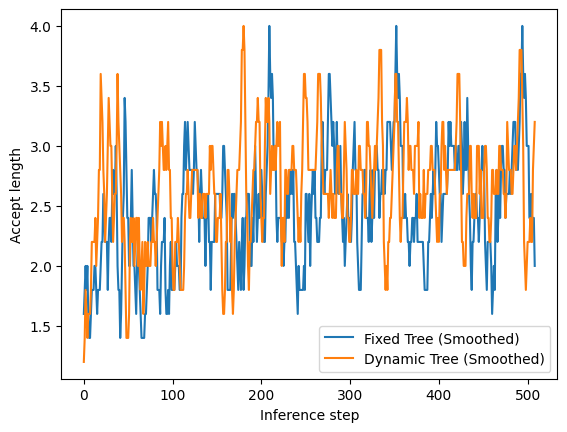

Avg. tokens for inference for fixed tree: 2.462
Avg. tokens for inference for dynamic tree: 2.637


In [22]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smoothed plots
window_size = 5
plt.plot(moving_average(accept_lengths_tree, window_size), label='Fixed Tree (Smoothed)', color='tab:blue')
plt.plot(moving_average(accept_lengths_tree_plus, window_size), label='Dynamic Tree (Smoothed)', color='tab:orange')

plt.xlabel('Inference step')
plt.ylabel('Accept length')
plt.legend()
plt.show()

print(f"Avg. tokens for inference for fixed tree: {np.mean(accept_lengths_tree):.3f}", )
print(f"Avg. tokens for inference for dynamic tree: {np.mean(accept_lengths_tree_plus):.3f}")

